In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/readme.html


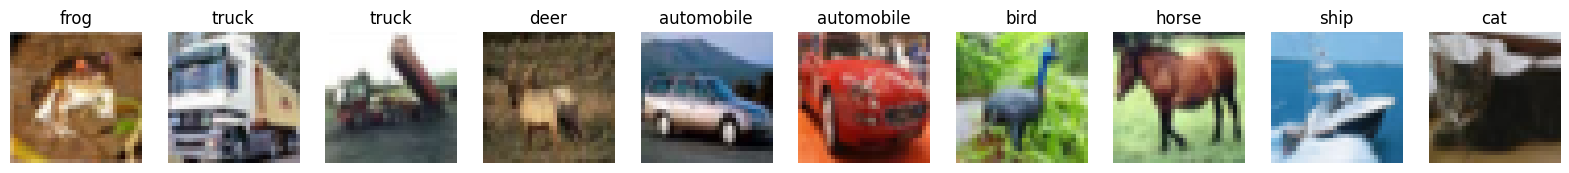

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

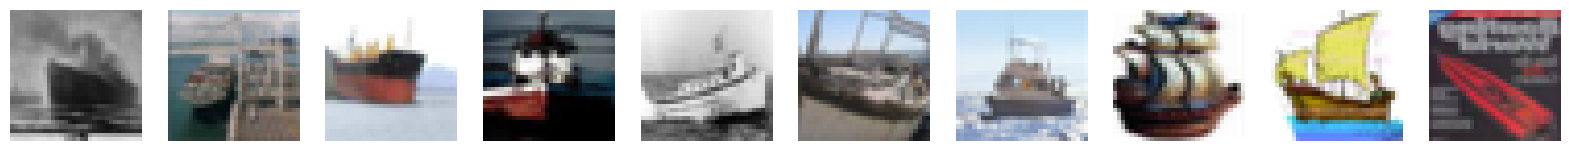

In [5]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')

# Extract images and convert back to image format
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [6]:
!pip install torchsummary

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

# Load Data

In [8]:
# Created a CustomCIFAR10 Dataset class in order to increase the ease of performing the transformations and 
# collecting the data from the train and test batches to feed into the model
class CustomCIFAR10(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        if self.train:
            self.data = []
            self.labels = []
            for i in range(1, 6):
                filename = os.path.join(self.root_dir, f'data_batch_{i}')
                batch_data = self._unpickle(filename)
                self.data.append(batch_data[b'data'])
                self.labels += batch_data[b'labels']
            self.data = np.concatenate(self.data, axis=0)
        else:
            filename = os.path.join(self.root_dir, 'test_batch')
            batch_data = self._unpickle(filename)
            self.data = batch_data[b'data']
            self.labels = batch_data[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].reshape(3, 32, 32).transpose((1, 2, 0))  # Reshape image data
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def _unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [9]:
# Performing the transforms needed for the train batches to input into model
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Performing the transforms needed for the test batch to input into model
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load custom CIFAR-10 dataset
trainset = CustomCIFAR10(root_dir=cifar10_dir, transform=transform_train, train=True)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CustomCIFAR10(root_dir=cifar10_dir, transform=transform_test, train=False)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Create Modified ResNet Model

In [10]:
# This is our modified ResNetModel built from BasicBlocks and called at the end with the
# ResNet18 function that we use to setup the block configuration
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
#         self.in_planes = 64
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)

#         self.in_planes = 32
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
#         self.linear = nn.Linear(256*block.expansion, num_classes)

        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [3,4,5,2])

In [11]:
# setting device for running notebook for training
device = 'cuda'
model = ResNet18().to(device)

In [12]:
# Set the optimizer, loss function, and scheduler. 
# We utilized SGD, Cross-entropy loss, and CosineAnnealingLR scheduler
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=70)

In [13]:
# A summary of the model so we can view the # of parameters and block configuration
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

# Train, Test, and Evaluate Model

In [14]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.*correct/total
    return train_loss, train_acc

In [15]:
def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100.*correct/total
    return test_loss, test_acc

In [18]:
# We used 70 epochs for training as it was a nice in between from 50 and 100 epochs
num_epochs = 70

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
    test_loss, test_acc = test(model, criterion, test_loader, device)
    scheduler.step() #call the scheduler step for the learning rate scheduler


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


  1%|▏         | 1/70 [00:49<56:51, 49.44s/it]

Epoch 1/70, Train Loss: 0.6428, Train Acc: 77.95%, Test Loss: 0.6676, Test Acc: 77.25%


  3%|▎         | 2/70 [01:38<55:48, 49.24s/it]

Epoch 2/70, Train Loss: 0.5900, Train Acc: 79.74%, Test Loss: 0.6360, Test Acc: 78.78%


  4%|▍         | 3/70 [02:27<54:59, 49.25s/it]

Epoch 3/70, Train Loss: 0.5517, Train Acc: 81.05%, Test Loss: 0.6538, Test Acc: 78.21%


  6%|▌         | 4/70 [03:16<54:08, 49.22s/it]

Epoch 4/70, Train Loss: 0.5171, Train Acc: 82.25%, Test Loss: 0.5992, Test Acc: 79.34%


  7%|▋         | 5/70 [04:06<53:19, 49.23s/it]

Epoch 5/70, Train Loss: 0.4985, Train Acc: 82.96%, Test Loss: 0.6848, Test Acc: 76.92%


  9%|▊         | 6/70 [04:55<52:31, 49.24s/it]

Epoch 6/70, Train Loss: 0.4777, Train Acc: 83.57%, Test Loss: 0.6078, Test Acc: 80.25%


 10%|█         | 7/70 [05:44<51:40, 49.22s/it]

Epoch 7/70, Train Loss: 0.4621, Train Acc: 84.32%, Test Loss: 0.6032, Test Acc: 79.48%


 11%|█▏        | 8/70 [06:33<50:52, 49.24s/it]

Epoch 8/70, Train Loss: 0.4481, Train Acc: 84.74%, Test Loss: 0.6087, Test Acc: 79.14%


 13%|█▎        | 9/70 [07:23<50:02, 49.23s/it]

Epoch 9/70, Train Loss: 0.4334, Train Acc: 85.11%, Test Loss: 0.8259, Test Acc: 74.29%


 14%|█▍        | 10/70 [08:12<49:12, 49.21s/it]

Epoch 10/70, Train Loss: 0.4255, Train Acc: 85.52%, Test Loss: 0.4945, Test Acc: 82.88%


 16%|█▌        | 11/70 [09:01<48:23, 49.21s/it]

Epoch 11/70, Train Loss: 0.4053, Train Acc: 86.07%, Test Loss: 0.4585, Test Acc: 84.74%


 17%|█▋        | 12/70 [09:50<47:33, 49.21s/it]

Epoch 12/70, Train Loss: 0.3986, Train Acc: 86.47%, Test Loss: 0.4933, Test Acc: 83.15%


 19%|█▊        | 13/70 [10:40<46:46, 49.23s/it]

Epoch 13/70, Train Loss: 0.3900, Train Acc: 86.66%, Test Loss: 0.5563, Test Acc: 81.05%


 20%|██        | 14/70 [11:29<45:56, 49.23s/it]

Epoch 14/70, Train Loss: 0.3816, Train Acc: 86.90%, Test Loss: 0.6186, Test Acc: 80.16%


 21%|██▏       | 15/70 [12:18<45:08, 49.25s/it]

Epoch 15/70, Train Loss: 0.3713, Train Acc: 87.34%, Test Loss: 0.5321, Test Acc: 82.16%


 23%|██▎       | 16/70 [13:07<44:19, 49.26s/it]

Epoch 16/70, Train Loss: 0.3634, Train Acc: 87.72%, Test Loss: 0.4849, Test Acc: 83.40%


 24%|██▍       | 17/70 [13:57<43:30, 49.26s/it]

Epoch 17/70, Train Loss: 0.3487, Train Acc: 88.07%, Test Loss: 0.4519, Test Acc: 85.01%


 26%|██▌       | 18/70 [14:46<42:41, 49.26s/it]

Epoch 18/70, Train Loss: 0.3451, Train Acc: 88.17%, Test Loss: 0.5531, Test Acc: 82.36%


 27%|██▋       | 19/70 [15:35<41:52, 49.27s/it]

Epoch 19/70, Train Loss: 0.3317, Train Acc: 88.59%, Test Loss: 0.4863, Test Acc: 83.49%


 29%|██▊       | 20/70 [16:24<41:03, 49.28s/it]

Epoch 20/70, Train Loss: 0.3281, Train Acc: 88.80%, Test Loss: 0.4569, Test Acc: 84.98%


 30%|███       | 21/70 [17:14<40:13, 49.25s/it]

Epoch 21/70, Train Loss: 0.3221, Train Acc: 89.13%, Test Loss: 0.5466, Test Acc: 82.31%


 31%|███▏      | 22/70 [18:03<39:22, 49.23s/it]

Epoch 22/70, Train Loss: 0.3090, Train Acc: 89.41%, Test Loss: 0.4506, Test Acc: 85.42%


 33%|███▎      | 23/70 [18:52<38:31, 49.18s/it]

Epoch 23/70, Train Loss: 0.3073, Train Acc: 89.58%, Test Loss: 0.4471, Test Acc: 85.43%


 34%|███▍      | 24/70 [19:41<37:40, 49.13s/it]

Epoch 24/70, Train Loss: 0.2968, Train Acc: 89.84%, Test Loss: 0.3921, Test Acc: 86.68%


 36%|███▌      | 25/70 [20:30<36:48, 49.08s/it]

Epoch 25/70, Train Loss: 0.2900, Train Acc: 90.14%, Test Loss: 0.4228, Test Acc: 85.49%


 37%|███▋      | 26/70 [21:19<35:58, 49.05s/it]

Epoch 26/70, Train Loss: 0.2798, Train Acc: 90.38%, Test Loss: 0.4379, Test Acc: 85.62%


 39%|███▊      | 27/70 [22:08<35:07, 49.02s/it]

Epoch 27/70, Train Loss: 0.2738, Train Acc: 90.69%, Test Loss: 0.3534, Test Acc: 88.26%


 40%|████      | 28/70 [22:57<34:18, 49.01s/it]

Epoch 28/70, Train Loss: 0.2648, Train Acc: 90.92%, Test Loss: 0.3834, Test Acc: 87.30%


 41%|████▏     | 29/70 [23:46<33:28, 48.99s/it]

Epoch 29/70, Train Loss: 0.2562, Train Acc: 91.31%, Test Loss: 0.4418, Test Acc: 86.03%


 43%|████▎     | 30/70 [24:35<32:38, 48.96s/it]

Epoch 30/70, Train Loss: 0.2479, Train Acc: 91.52%, Test Loss: 0.4692, Test Acc: 85.31%


 44%|████▍     | 31/70 [25:23<31:48, 48.95s/it]

Epoch 31/70, Train Loss: 0.2457, Train Acc: 91.54%, Test Loss: 0.4402, Test Acc: 86.34%


 46%|████▌     | 32/70 [26:12<30:59, 48.92s/it]

Epoch 32/70, Train Loss: 0.2333, Train Acc: 92.04%, Test Loss: 0.4326, Test Acc: 86.42%


 47%|████▋     | 33/70 [27:01<30:09, 48.91s/it]

Epoch 33/70, Train Loss: 0.2267, Train Acc: 92.05%, Test Loss: 0.3744, Test Acc: 87.63%


 49%|████▊     | 34/70 [27:50<29:20, 48.91s/it]

Epoch 34/70, Train Loss: 0.2190, Train Acc: 92.50%, Test Loss: 0.3429, Test Acc: 88.94%


 50%|█████     | 35/70 [28:39<28:32, 48.94s/it]

Epoch 35/70, Train Loss: 0.2078, Train Acc: 92.91%, Test Loss: 0.4146, Test Acc: 86.69%


 51%|█████▏    | 36/70 [29:28<27:45, 48.98s/it]

Epoch 36/70, Train Loss: 0.2012, Train Acc: 93.10%, Test Loss: 0.2987, Test Acc: 90.03%


 53%|█████▎    | 37/70 [30:17<26:57, 49.02s/it]

Epoch 37/70, Train Loss: 0.1872, Train Acc: 93.66%, Test Loss: 0.3325, Test Acc: 89.29%


 54%|█████▍    | 38/70 [31:06<26:08, 49.00s/it]

Epoch 38/70, Train Loss: 0.1779, Train Acc: 93.90%, Test Loss: 0.2968, Test Acc: 90.46%


 56%|█████▌    | 39/70 [31:55<25:18, 48.99s/it]

Epoch 39/70, Train Loss: 0.1715, Train Acc: 94.10%, Test Loss: 0.2958, Test Acc: 90.37%


 57%|█████▋    | 40/70 [32:44<24:28, 48.96s/it]

Epoch 40/70, Train Loss: 0.1574, Train Acc: 94.53%, Test Loss: 0.2973, Test Acc: 90.61%


 59%|█████▊    | 41/70 [33:33<23:39, 48.94s/it]

Epoch 41/70, Train Loss: 0.1539, Train Acc: 94.65%, Test Loss: 0.3467, Test Acc: 89.19%


 60%|██████    | 42/70 [34:22<22:49, 48.92s/it]

Epoch 42/70, Train Loss: 0.1376, Train Acc: 95.23%, Test Loss: 0.2990, Test Acc: 90.37%


 61%|██████▏   | 43/70 [35:11<22:00, 48.92s/it]

Epoch 43/70, Train Loss: 0.1284, Train Acc: 95.49%, Test Loss: 0.3029, Test Acc: 90.80%


 63%|██████▎   | 44/70 [36:00<21:11, 48.89s/it]

Epoch 44/70, Train Loss: 0.1165, Train Acc: 96.01%, Test Loss: 0.2480, Test Acc: 92.42%


 64%|██████▍   | 45/70 [36:49<20:22, 48.89s/it]

Epoch 45/70, Train Loss: 0.1085, Train Acc: 96.29%, Test Loss: 0.3018, Test Acc: 91.03%


 66%|██████▌   | 46/70 [37:37<19:33, 48.88s/it]

Epoch 46/70, Train Loss: 0.1008, Train Acc: 96.56%, Test Loss: 0.2849, Test Acc: 91.40%


 67%|██████▋   | 47/70 [38:26<18:44, 48.87s/it]

Epoch 47/70, Train Loss: 0.0896, Train Acc: 96.96%, Test Loss: 0.2355, Test Acc: 92.72%


 69%|██████▊   | 48/70 [39:15<17:55, 48.86s/it]

Epoch 48/70, Train Loss: 0.0756, Train Acc: 97.47%, Test Loss: 0.2553, Test Acc: 92.32%


 70%|███████   | 49/70 [40:04<17:05, 48.85s/it]

Epoch 49/70, Train Loss: 0.0681, Train Acc: 97.75%, Test Loss: 0.2302, Test Acc: 92.83%


 71%|███████▏  | 50/70 [40:53<16:17, 48.86s/it]

Epoch 50/70, Train Loss: 0.0562, Train Acc: 98.15%, Test Loss: 0.2504, Test Acc: 92.82%


 73%|███████▎  | 51/70 [41:42<15:28, 48.86s/it]

Epoch 51/70, Train Loss: 0.0533, Train Acc: 98.27%, Test Loss: 0.2259, Test Acc: 93.56%


 74%|███████▍  | 52/70 [42:31<14:39, 48.86s/it]

Epoch 52/70, Train Loss: 0.0413, Train Acc: 98.67%, Test Loss: 0.2338, Test Acc: 93.47%


 76%|███████▌  | 53/70 [43:19<13:50, 48.86s/it]

Epoch 53/70, Train Loss: 0.0330, Train Acc: 98.96%, Test Loss: 0.2286, Test Acc: 93.78%


 77%|███████▋  | 54/70 [44:08<13:01, 48.87s/it]

Epoch 54/70, Train Loss: 0.0246, Train Acc: 99.29%, Test Loss: 0.2249, Test Acc: 93.82%


 79%|███████▊  | 55/70 [44:57<12:13, 48.87s/it]

Epoch 55/70, Train Loss: 0.0200, Train Acc: 99.40%, Test Loss: 0.2210, Test Acc: 94.14%


 80%|████████  | 56/70 [45:46<11:24, 48.87s/it]

Epoch 56/70, Train Loss: 0.0157, Train Acc: 99.57%, Test Loss: 0.2138, Test Acc: 94.23%


 81%|████████▏ | 57/70 [46:35<10:35, 48.87s/it]

Epoch 57/70, Train Loss: 0.0116, Train Acc: 99.70%, Test Loss: 0.2200, Test Acc: 94.28%


 83%|████████▎ | 58/70 [47:24<09:46, 48.86s/it]

Epoch 58/70, Train Loss: 0.0093, Train Acc: 99.80%, Test Loss: 0.2108, Test Acc: 94.54%


 84%|████████▍ | 59/70 [48:13<08:57, 48.87s/it]

Epoch 59/70, Train Loss: 0.0073, Train Acc: 99.85%, Test Loss: 0.2058, Test Acc: 94.75%


 86%|████████▌ | 60/70 [49:02<08:08, 48.88s/it]

Epoch 60/70, Train Loss: 0.0065, Train Acc: 99.86%, Test Loss: 0.2073, Test Acc: 94.68%


 87%|████████▋ | 61/70 [49:50<07:19, 48.87s/it]

Epoch 61/70, Train Loss: 0.0055, Train Acc: 99.88%, Test Loss: 0.2061, Test Acc: 94.80%


 89%|████████▊ | 62/70 [50:39<06:31, 48.88s/it]

Epoch 62/70, Train Loss: 0.0049, Train Acc: 99.92%, Test Loss: 0.2034, Test Acc: 94.80%


 90%|█████████ | 63/70 [51:28<05:42, 48.87s/it]

Epoch 63/70, Train Loss: 0.0047, Train Acc: 99.91%, Test Loss: 0.2007, Test Acc: 94.85%


 91%|█████████▏| 64/70 [52:17<04:53, 48.87s/it]

Epoch 64/70, Train Loss: 0.0042, Train Acc: 99.93%, Test Loss: 0.2029, Test Acc: 94.87%


 93%|█████████▎| 65/70 [53:06<04:04, 48.87s/it]

Epoch 65/70, Train Loss: 0.0043, Train Acc: 99.93%, Test Loss: 0.2021, Test Acc: 94.77%


 94%|█████████▍| 66/70 [53:55<03:15, 48.87s/it]

Epoch 66/70, Train Loss: 0.0044, Train Acc: 99.92%, Test Loss: 0.2028, Test Acc: 94.84%


 96%|█████████▌| 67/70 [54:44<02:26, 48.88s/it]

Epoch 67/70, Train Loss: 0.0039, Train Acc: 99.94%, Test Loss: 0.2013, Test Acc: 94.78%


 97%|█████████▋| 68/70 [55:33<01:37, 48.90s/it]

Epoch 68/70, Train Loss: 0.0042, Train Acc: 99.94%, Test Loss: 0.2029, Test Acc: 94.75%


 99%|█████████▊| 69/70 [56:22<00:48, 48.90s/it]

Epoch 69/70, Train Loss: 0.0041, Train Acc: 99.95%, Test Loss: 0.2019, Test Acc: 94.83%


100%|██████████| 70/70 [57:10<00:00, 49.01s/it]

Epoch 70/70, Train Loss: 0.0042, Train Acc: 99.94%, Test Loss: 0.2008, Test Acc: 94.85%


In [24]:
#Extracting the images from the unlabeled custom test set 
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')
# Extract images
inputs = cifar10_batch[b'data']
print(inputs.shape)


ids = []
predictions = []
model.eval()
for i in tqdm(range(inputs.shape[0])):
    data = transform_test(inputs  [i].reshape(3, 32, 32).transpose((1, 2, 0))).to(device)
    outputs = model(data.unsqueeze(0))
    
    _, predicted = outputs.max(1)
    
    ids.append(i)
    predictions.append(predicted.item())


print('Generating submission.csv file...')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='ID,Labels',
    comments='',
)

# Look at the first few predictions
!head submission.csv

(10000, 3072)


100%|██████████| 10000/10000 [00:53<00:00, 185.82it/s]


Generating submission.csv file...
ID,Labels
0,8
1,8
2,8
3,8
4,8
5,8
6,8
7,7
8,8


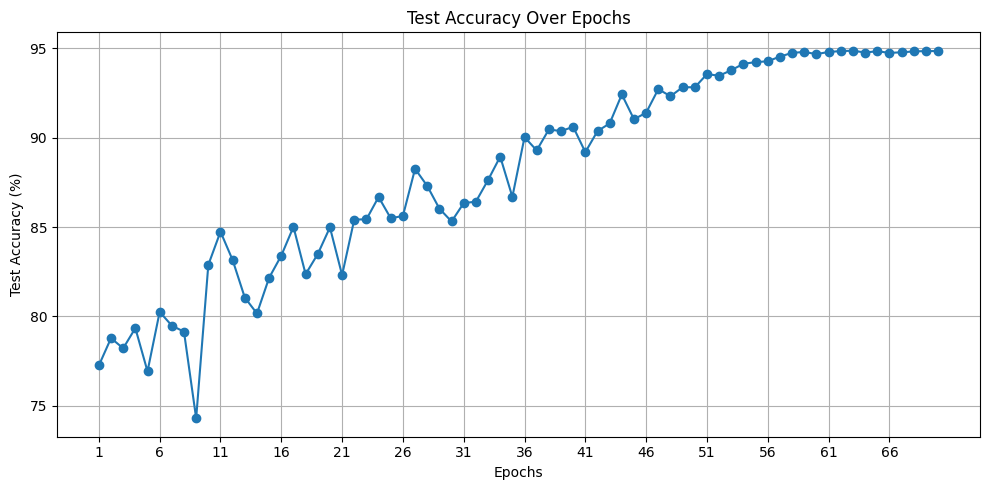

In [9]:
import matplotlib.pyplot as plt

# Test accuracy values
test_acc_values = [77.25, 78.78, 78.21, 79.34, 76.92, 80.25, 79.48, 79.14, 74.29, 82.88, 84.74, 83.15, 81.05, 80.16, 82.16, 83.40, 85.01, 82.36, 83.49, 84.98, 82.31, 85.42, 85.43, 86.68, 85.49, 85.62, 88.26, 87.30, 86.03, 85.31, 86.34, 86.42, 87.63, 88.94, 86.69, 90.03, 89.29, 90.46, 90.37, 90.61, 89.19, 90.37, 90.80, 92.42, 91.03, 91.40, 92.72, 92.32, 92.83, 92.82, 93.56, 93.47, 93.78, 94.14, 94.23, 94.28, 94.54, 94.75, 94.80, 94.68, 94.80, 94.85, 94.87, 94.77, 94.84, 94.75, 94.78, 94.83, 94.85, 94.85]

# Number of epochs
num_epochs = 70

# Epochs
epochs = range(1, num_epochs + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_acc_values, marker='o', linestyle='-')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, 5))  # Adjust x-axis ticks for better readability
plt.tight_layout()
plt.show()


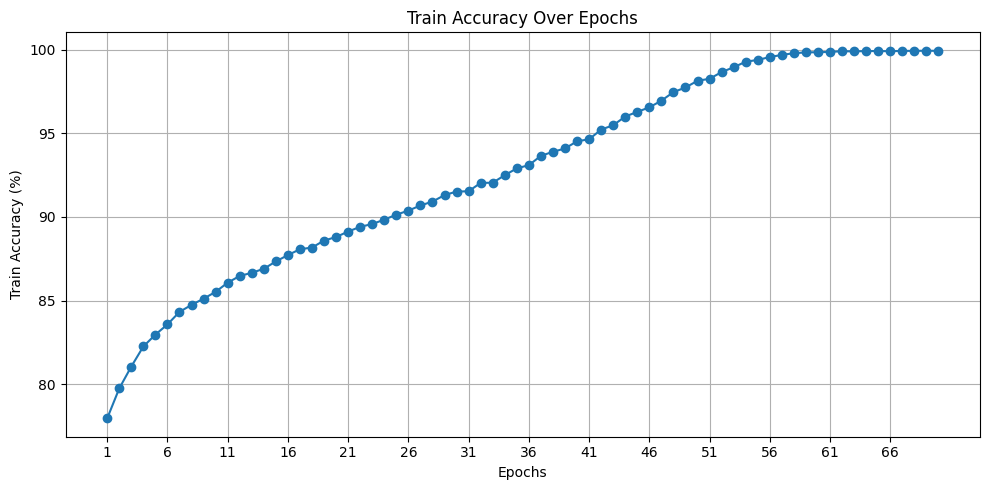

In [2]:
import matplotlib.pyplot as plt

# Train accuracy values
train_acc_values = [77.95, 79.74, 81.05, 82.25, 82.96, 83.57, 84.32, 84.74, 85.11, 85.52, 86.07, 86.47, 86.66, 86.90, 87.34, 87.72, 88.07, 88.17, 88.59, 88.80, 89.13, 89.41, 89.58, 89.84, 90.14, 90.38, 90.69, 90.92, 91.31, 91.52, 91.54, 92.04, 92.05, 92.50, 92.91, 93.10, 93.66, 93.90, 94.10, 94.53, 94.65, 95.23, 95.49, 96.01, 96.29, 96.56, 96.96, 97.47, 97.75, 98.15, 98.27, 98.67, 98.96, 99.29, 99.40, 99.57, 99.70, 99.80, 99.85, 99.86, 99.88, 99.92, 99.91, 99.93, 99.93, 99.92, 99.94, 99.94, 99.95,99.94]

# Number of epochs
num_epochs = 70

# Epochs
epochs = range(1, num_epochs + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_values, marker='o', linestyle='-')
plt.title('Train Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, 5))
plt.tight_layout()
plt.show()


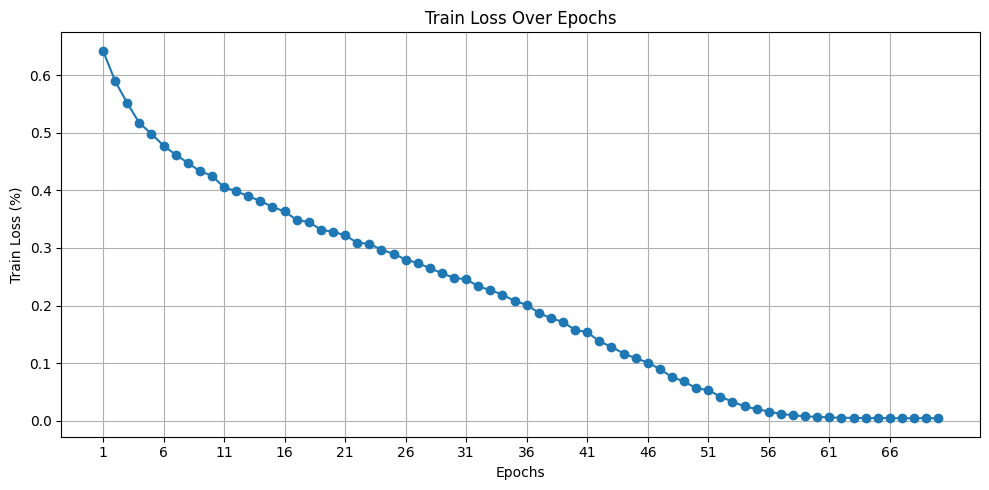

In [47]:
import matplotlib.pyplot as plt

# Train Loss values
train_loss_values = [0.6428, 0.5900, 0.5517, 0.5171, 0.4985, 0.4777, 0.4621, 0.4481, 0.4334, 0.4255, 0.4053, 0.3986, 0.3900, 0.3816, 0.3713, 0.3634, 0.3487, 0.3451, 0.3317, 0.3281, 0.3221, 0.3090, 0.3073, 0.2968, 0.2900, 0.2798, 0.2738, 0.2648, 0.2562, 0.2479, 0.2457, 0.2333, 0.2267, 0.2190, 0.2078, 0.2012, 0.1872, 0.1779, 0.1715, 0.1574, 0.1539, 0.1376, 0.1284, 0.1165, 0.1085, 0.1008, 0.0896, 0.0756, 0.0681, 0.0562, 0.0533, 0.0413, 0.0330, 0.0246, 0.0200, 0.0157, 0.0116, 0.0093, 0.0073, 0.0065, 0.0055, 0.0049, 0.0047, 0.0042, 0.0043, 0.0044, 0.0039, 0.0042, 0.0041, 0.0042]

# Number of epochs
num_epochs = 70

# Epochs
epochs = range(1, num_epochs + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_values, marker='o', linestyle='-')
plt.title('Train Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss (%)')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, 5))  
plt.tight_layout()
plt.show()


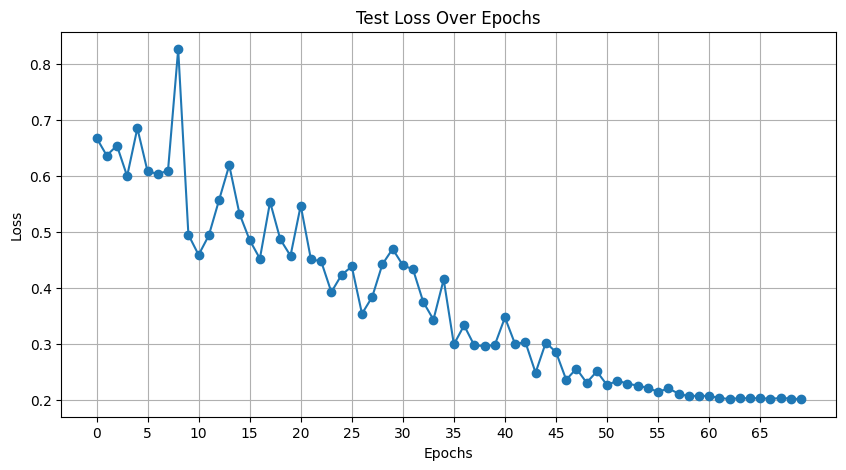

In [49]:
import matplotlib.pyplot as plt
num_epochs = 70

# Epochs
epochs = range(num_epochs)

test_loss_values = [0.6676, 0.6360, 0.6538, 0.5992, 0.6848, 0.6078, 0.6032, 0.6087, 0.8259, 0.4945, 0.4585, 0.4933, 0.5563, 0.6186, 0.5321, 0.4849, 0.4519, 0.5531, 0.4863, 0.4569, 0.5466, 0.4506, 0.4471, 0.3921, 0.4228, 0.4379, 0.3534, 0.3834, 0.4418, 0.4692, 0.4402, 0.4326, 0.3744, 0.3429, 0.4146, 0.2987, 0.3325, 0.2968, 0.2958, 0.2973, 0.3467, 0.2990, 0.3029, 0.2480, 0.3018, 0.2849, 0.2355, 0.2553, 0.2302, 0.2504, 0.2259, 0.2338, 0.2286, 0.2249, 0.2210, 0.2138, 0.2200, 0.2108, 0.2058, 0.2073, 0.2061, 0.2034, 0.2007, 0.2029, 0.2021, 0.2028, 0.2013, 0.2029, 0.2019, 0.2008]
# Plot test loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_loss_values, marker='o', linestyle='-')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(0, num_epochs, 5))  # Adjust x-axis ticks for better readability
plt.show()
